In [25]:
import pandas as pd
import numpy as np
from typing import List
import matplotlib.pyplot as plt

Read and analyze the data

In [2]:
df_beijing = pd.read_csv("data/Beijing_labeled.csv")
df_shenyang = pd.read_csv("data/Shenyang_labeled.csv")
df_train = pd.concat([df_beijing, df_shenyang], axis=0)

In [3]:
df_train

,season,DEWP,HUMI,PRES,TEMP,Iws,precipitation,cbwd_NE,cbwd_NW,cbwd_SE,PM_HIGH
0,4,-8.0,79.00,1026.0,-5.0,23.69,0.0,0,0,1,1.0
1,4,-11.0,85.00,1021.0,-9.0,105.93,1.1,0,0,1,0.0
2,4,-21.0,43.00,1030.0,-11.0,117.55,0.0,0,1,0,0.0
3,4,-25.0,33.00,1034.0,-12.0,39.35,0.0,1,0,0,0.0
4,4,-24.0,30.00,1034.0,-10.0,59.00,0.0,1,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
819,4,-22.0,50.63,1038.0,-14.0,4.00,0.0,0,0,0,1.0
820,4,-16.0,52.47,1034.0,-8.0,4.00,0.0,0,0,0,1.0
821,4,-13.0,45.91,1028.0,-3.0,40.00,0.0,0,0,1,1.0
822,4,-4.0,80.04,1029.0,-1.0,6.00,0.0,0,1,0,1.0


In [4]:
def print_label_stats(df: pd.DataFrame) -> None:
    label_stats = df.iloc[::,-1].value_counts()
    cnt_neg, cnt_pos = label_stats
    print("Label ratio:")
    print(f"Positive (polluted): {cnt_pos / (cnt_neg + cnt_pos)}")
    print(f"Negative (not polluted): {cnt_neg / (cnt_neg + cnt_pos)}")

Inspect label distribution in data

In [5]:
# inspect the training data
print_label_stats(df_train)

Label ratio:
Positive (polluted): 0.27495682210708117
Negative (not polluted): 0.7250431778929188


In [6]:
# read test data
df_guangzhou = pd.read_csv("data/Guangzhou_labeled.csv")
df_shanghai = pd.read_csv("data/Shanghai_labeled.csv")


In [7]:
# inspect the test data
print("Guangzhou")
print_label_stats(df_guangzhou)

print("Shanghai")
print_label_stats(df_shanghai)

Guangzhou
Label ratio:
Positive (polluted): 0.06360946745562131
Negative (not polluted): 0.9363905325443787
Shanghai
Label ratio:
Positive (polluted): 0.09844559585492228
Negative (not polluted): 0.9015544041450777


In [9]:
test_ratio = df_guangzhou.shape[0] / (df_train.shape[0] + df_guangzhou.shape[0])
train_ratio = 1 - test_ratio
print(f"Train data ratio: {train_ratio}")
print(f"Test data ratio: {test_ratio}")


Train data ratio: 0.6816576406875441
Test data ratio: 0.31834235931245586


Prepare for training 

In [10]:
X_train = df_train.iloc[::, :-1].to_numpy()  # features
Y_train = df_train.iloc[::, -1].to_numpy()  # labels

X_test_guangzhou = df_guangzhou.iloc[::, :-1].to_numpy()  # features
Y_test_guangzhou = df_guangzhou.iloc[::, -1].to_numpy()  # labels

X_test_shanghai = df_shanghai.iloc[::, :-1].to_numpy()  # features
Y_test_shanghai = df_shanghai.iloc[::, -1].to_numpy()  # labels

Implementation of KNN algorithm

In [19]:
import numpy as np


class KNN:
    def __init__(self, X: np.ndarray, Y: np.ndarray, k: int = 10):
        self.X = X
        self.Y = Y
        self.k = k

    def predict(self, x: np.ndarray) -> int:
        """
        Predict class for given vector x
        """
        self.neighbors = np.zeros((self.X.shape[0], 3))

        for idx, row in enumerate(self.X):
            dist = self._euclid_distance(x, row)
            item_class = self.Y[idx]
            self.neighbors = self._update_neighbors(
                self.neighbors, item_class, dist, idx
            )

        # sort calculated neighbors by distance
        self.neighbors = self.neighbors[self.neighbors[:, 0].argsort()][::-1]
        prediction = self._pick_max()
        return prediction

    def score(self, X: np.ndarray, Y: np.ndarray) -> float:
        """
        Calculate accuracy for given data set
        """
        # make predictions for test set
        predictions = np.zeros(X.shape[0])
        for idx, x in enumerate(X):
            predictions[idx] = self.predict(x)

        # calc accuracy
        accuracy = np.sum(np.equal(predictions, Y)) / Y.shape[0]
        return accuracy

    def _pick_max(self) -> int:
        """
        Pick k nearest neighbors and decide majority vote for predicted class
        """
        k_neighbors = self.neighbors[: self.k, ::]
        cnt_zero = np.count_nonzero(k_neighbors == 0)
        cnt_one = np.count_nonzero(k_neighbors == 1)
        return 0 if cnt_zero > cnt_one else 1

    def _update_neighbors(
        self, neighbors: np.ndarray, item_class: int, dist: float, idx: int
    ) -> np.ndarray:
        """
        Add calculated neighbor to array with its distance, actual class and the index in the
        original dataframe
        """
        # add new neighbor to array
        neighbors[idx][0], neighbors[idx][1], neighbors[idx][2] = dist, item_class, idx
        return neighbors

    def _euclid_distance(self, x: np.ndarray, y: np.ndarray) -> float:
        """Calculate euclidian distance of vectors"""
        dist = np.linalg.norm(x - y)
        return dist


In [26]:
def cross_validation(k_vals: range, X_train: np.ndarray, Y_train: np.ndarray):
    """
    Cross validate different k values to find the optimal one with the highest accuracy
    """
    results = {}
    for k in k_vals:
        knn = KNN(X_train, Y_train, k=k)
        results[k] = knn.score(X_train, Y_train)
    return results


In [24]:
# can take some minutes to run depending on the amount of k values
k_vals = range(1, 20)
k_results = cross_validation(
    k_vals, X_train, Y_train
)
opt_k = max(k_results, key=k_results.get)

print(k_results)
print(f"Optimal k = {opt_k} with accuracy of {k_results[opt_k]}")


{1: 0.7215889464594127, 2: 0.7170984455958549, 3: 0.718825561312608, 4: 0.7105354058721934, 5: 0.7132987910189983, 6: 0.7094991364421416, 7: 0.7105354058721934, 8: 0.7084628670120898, 9: 0.7084628670120898, 10: 0.7081174438687392, 11: 0.7081174438687392, 12: 0.7077720207253886, 13: 0.7094991364421416, 14: 0.7088082901554404, 15: 0.7112262521588947, 16: 0.7098445595854922, 17: 0.71433506044905, 18: 0.7108808290155441, 19: 0.7136442141623489}
Optimal k = 1 with accuracy of 0.7215889464594127


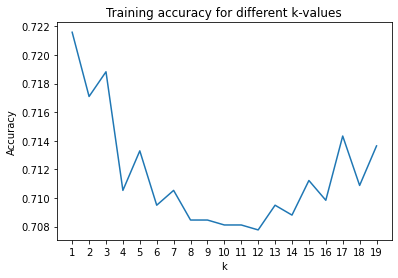

In [32]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(k_vals, k_results.values())
ax.set_title('Training accuracy for different k-values')
ax.set_ylabel('Accuracy')
ax.set_xlabel('k')
ax.xaxis.set_ticks(k_vals)
fig.show()
fig.savefig("k_vals.png")

In [33]:
# use model with optimal hyperparameter k
knn = KNN(X_train, Y_train, k=opt_k)

In [34]:
train_acc = knn.score(X_train, Y_train)
print(f"Training accuracy of model: {round(train_acc*100, 2)}")

Training accuracy of model: 72.16


In [35]:
test_acc_guangzhou = knn.score(X_test_guangzhou, Y_test_guangzhou)
print(f"Test accuracy of model for guangzhou data: {round(test_acc_guangzhou*100, 2)}")


Test accuracy of model for guangzhou data: 93.64


In [36]:
test_acc_shanghai = knn.score(X_test_shanghai, Y_test_shanghai)
print(f"Test accuracy of model for shanghai data: {round(test_acc_shanghai*100, 2)}")


Test accuracy of model for shanghai data: 90.08
